In [38]:
# Common data handling libraries
import os
import h5py
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time 

# NLTK for test processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

# Tensorflow for model building
import tensorflow as tf
from tensorflow.keras import models

In [39]:
# FLICKR8K_IMG_PATH = '/Users/apple/flickr8k/Flicker8k_Dataset/'
# FLICKR8K_TEXT_PATH = '/Users/apple/flickr8k/Flickr8k_text/'
# FLICKR8K_TOKEN_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr8k.token.txt')
# FLICKR8K_TRAIN_IMG_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr_8k.trainImages.txt')
# FLICKR8K_VALID_IMG_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr_8k.devImages.txt')
# FLICKR8K_TEST_IMG_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr_8k.testImages.txt')

In [40]:
df = pd.DataFrame(data={"image_name":list(os.listdir("/Users/apple/rarerabbit_images")),
                                        "title":list(os.listdir("/Users/apple/rarerabbit_images"))})
df = df[:3423]

In [41]:
df["image_name"]  = df["image_name"].apply(lambda x: "/Users/apple/rarerabbit_images/"+x)
df["caption"] = df["title"].apply(lambda x: x.lower().replace("_"," "))

In [45]:
# df = df.drop([3423],axis=0)

In [46]:
df[df["image_name"]=="/Users/apple/rarerabbit_images/.ipynb_checkpoints"]

,image_name,title,caption


In [42]:
df.iloc[214:217]

,image_name,title,caption
214,/Users/apple/rarerabbit_images/RANEO_CHECK_SLI...,RANEO_CHECK_SLIM_FIT_MEN_SHIRT_MAROON,raneo check slim fit men shirt maroon
215,/Users/apple/rarerabbit_images/PASTO_MENS_TROU...,PASTO_MENS_TROUSERS_PURPLE,pasto mens trousers purple
216,/Users/apple/rarerabbit_images/DELUX_WOMENS_FI...,DELUX_WOMENS_FITTED_JACKET_MAROON,delux womens fitted jacket maroon


In [43]:
def getImageList(filename):

    sel_image_id_list = list()

    with open(filename, 'r') as file:
        data = file.read()

    for line in data.split('\n'):
        image_id = line.split('#')[0]

        if len(image_id) > 1:
            sel_image_id_list.append(os.path.join(FLICKR8K_IMG_PATH, image_id))

    sel_image_id_list = list(set(sel_image_id_list))

    return sel_image_id_list

def preprocess_caption(caption):

    # tokenize and convert to lower case
    caption = [word.lower() for word in caption.split()]

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # remove punctuation from each word
    caption = [word.translate(table) for word in caption]

    # remove words with numbers in them
    caption = [word for word in caption if word.isalpha()]

    # store caption as string
    caption =  ' '.join(caption)

    return caption    


def get_wordnet_pos(word):
    # Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)    


def lemmatize_caption(caption, lemmatizer, stemmer):
    stop_words = list(set(stopwords.words('english')))
    return ' '.join(list(set([stemmer.stem(lemmatizer.lemmatize(word, get_wordnet_pos(word))) 
                     for word in nltk.word_tokenize(caption)
                     if word not in stop_words])))

In [44]:
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def preprocess_and_lemmatize(caption,stemmer,lemmatizer):
    # get the processed caption
    caption = preprocess_caption(caption)
    # get lemmatized caption
    lem_caption = lemmatize_caption(caption, lemmatizer, stemmer)
    return lem_caption

In [45]:
df["caption_lem"] = df["caption"].apply(lambda x: preprocess_and_lemmatize(x,stemmer,lemmatizer))

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.50, random_state=42)

In [46]:
top_n_attributes = 50

freq_dist = dict(nltk.FreqDist(nltk.word_tokenize(' '.join(train_df['caption_lem'].to_list()))).most_common(top_n_attributes-1))
attrib_vocab = freq_dist.keys()

# create the tokenizer
attrib_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=',')

# fit the tokenizer on the documents
caption_attrib_list = []
for caption in train_df['caption_lem']:
    attrib_list = [word for word in caption.split() if word in attrib_vocab]
    caption_attrib_list.append(",".join(attrib_list))            

attrib_tokenizer.fit_on_texts(caption_attrib_list)

attrib_vocab_size = len(attrib_tokenizer.word_counts) + 1 

In [47]:
def load_image_attribute(image_name, attribute_vec):
    image = tf.io.read_file(image_name.decode('utf-8'))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(image) 
    return img_tensor, attribute_vec

def load_image(image_name):
    image = tf.io.read_file(image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    img_tensor = tf.keras.applications.efficientnet.preprocess_input(image) 
    return img_tensor

def get_attribute_vector_from_caption(caption_list):
    # get the filtered words from tokenizer dictionary
    attrib_vocab = attrib_tokenizer.word_index.keys()

    # filter the caption words
    caption_attrib_list = []
    for caption in caption_list:
        attrib_list = [word for word in caption.split() if word in attrib_vocab]
        caption_attrib_list.append(",".join(attrib_list))

    attribute_vec = attrib_tokenizer.texts_to_matrix(caption_attrib_list, mode='binary')
    return attribute_vec

In [48]:
# get the attribuites vector from the caption
train_attrib_vec = get_attribute_vector_from_caption(train_df['caption_lem'].to_list())
valid_attrib_vec = get_attribute_vector_from_caption(valid_df['caption_lem'].to_list())

In [49]:
train_df["train_attrib_vec"] = list(train_attrib_vec)
valid_df["valid_attrib_vec"] = list(valid_attrib_vec)

In [50]:
train_df["train_attrib_vec"] = train_df["train_attrib_vec"].apply(lambda x: list(x))
valid_df["valid_attrib_vec"] = valid_df["valid_attrib_vec"].apply(lambda x: list(x))

In [51]:
X_train = train_df["image_name"].to_list()
y_train_bin = train_df["train_attrib_vec"].to_list()

In [52]:
X_val = valid_df["image_name"].to_list()
y_val_bin = valid_df["valid_attrib_vec"].to_list()

In [53]:
IMG_SIZE = 224 
CHANNELS = 3

In [54]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [55]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [56]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [57]:
train_df

,image_name,title,caption,caption_lem,train_attrib_vec
1874,/Users/apple/rarerabbit_images/SANTA_DENIM_FUL...,SANTA_DENIM_FULL_SLEEVE_MEN_SHIRT__WHITE,santa denim full sleeve men shirt white,santa denim white shirt sleev full men,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3094,/Users/apple/rarerabbit_images/FINN_TRACKSUIT_...,FINN_TRACKSUIT_GREY_MELANGE,finn tracksuit grey melange,melang tracksuit finn grey,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
776,/Users/apple/rarerabbit_images/PECAN_GRAPHIC_D...,PECAN_GRAPHIC_DESIGN_MENS_T_SHIRT_ORANGE,pecan graphic design mens t shirt orange,orang pecan design shirt graphic men,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2087,/Users/apple/rarerabbit_images/PLAY_LOGO_PRINT...,PLAY_LOGO_PRINT_MEN'S_T_SHIRT_BLUE,play logo print men's t shirt blue,print logo play shirt blue men,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
2603,/Users/apple/rarerabbit_images/REWIND_BLAZER_BLUE,REWIND_BLAZER_BLUE,rewind blazer blue,blue rewind blazer,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
1095,/Users/apple/rarerabbit_images/DOMINIQUE_3_PIE...,DOMINIQUE_3_PIECE_WOOL_SUIT_BEIGE,dominique 3 piece wool suit beige,piec wool beig suit dominiqu,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1130,/Users/apple/rarerabbit_images/GINNY_CHECKS_SL...,GINNY_CHECKS_SLIM_FIT_MENS_SHIRT_BLUE,ginny checks slim fit mens shirt blue,slim fit ginni shirt blue check men,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
1294,/Users/apple/rarerabbit_images/LAUAN_GRAPHIC_P...,LAUAN_GRAPHIC_PRINT_MENS_T_SHIRT_LILAC,lauan graphic print mens t shirt lilac,print lauan shirt lilac graphic men,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
860,/Users/apple/rarerabbit_images/CLICK_PRINTED_W...,CLICK_PRINTED_WOMENS_DRESS_PURPLE,click printed womens dress purple,print dress click purpl woman,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."


In [58]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [59]:
attrib_vocab

dict_keys(['men', 'shirt', 'plain', 'fit', 'slim', 'woman', 'blue', 'print', 'navi', 'black', 'green', 'white', 'trouser', 'polo', 'pink', 'check', 'top', 'grey', 'dress', 'jacket', 'beig', 'sleev', 'basic', 'maroon', 'linen', 'graphic', 'short', 'half', 'textur', 'yellow', 'design', 'oliv', 'knit', 'stripe', 'solid', 'orang', 'sweater', 'pant', 'brown', 'red', 'sweatshirt', 'denim', 'lycra', 'leather', 'purpl', 'tshirt', 'light', 'shoe', 'blazer'])

In [60]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

2022-10-06 09:38:09.050345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 906 of 1024
2022-10-06 09:38:10.409209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 50)


2022-10-06 09:38:16.233374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [61]:
efficientNet_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=True)
efficientNet_model.trainable = False

model = tf.keras.layers.Dropout(0.5)(efficientNet_model.layers[-2].output)
model = tf.keras.layers.BatchNormalization()(model)
model_output = tf.keras.layers.Dense(attrib_vocab_size, activation='sigmoid')(model)

# model = tf.keras.layers.Dropout(0.2)(efficientNet_model.layers[-2].output)
# model = tf.keras.layers.Dense(units=4096, activation='relu')(model)
# model = tf.keras.layers.Dropout(0.5)(model)
# model = tf.keras.layers.BatchNormalization()(model)
# model = tf.keras.layers.Dense(units=4096, activation='relu')(model)
# model = tf.keras.layers.Dropout(0.5)(model)
# model = tf.keras.layers.BatchNormalization()(model)
# model_output = tf.keras.layers.Dense(attrib_vocab_size, activation='sigmoid')(model)

efficientNet_model = tf.keras.Model(inputs=efficientNet_model.input, outputs=model_output)            

efficientNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])   
efficientNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [62]:
# for elem in train_ds:
#     print(elem)

Training attribute extractor...
Epoch 1/10


2022-10-06 09:38:56.420021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 967 of 1024
2022-10-06 09:38:57.044302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


11/11 [==============================] - ETA: 0s - loss: 17.0405 - accuracy: 0.0183
Epoch 1: val_loss improved from inf to 13.28760, saving model to /Users/apple/flickr8k/attribute_extractor_model_weights_v7.hdf5
11/11 [==============================] - 115s 9s/step - loss: 17.0405 - accuracy: 0.0183 - val_loss: 13.2876 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 16.6194 - accuracy: 0.0332
Epoch 2: val_loss improved from 13.28760 to 13.00000, saving model to /Users/apple/flickr8k/attribute_extractor_model_weights_v7.hdf5
11/11 [==============================] - 78s 7s/step - loss: 16.6194 - accuracy: 0.0332 - val_loss: 13.0000 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 16.2650 - accuracy: 0.0533
Epoch 3: val_loss improved from 13.00000 to 12.69262, saving model to /Users/apple/flickr8k/attribute_extractor_model_weights_v7.hdf5
11/11 [=============================

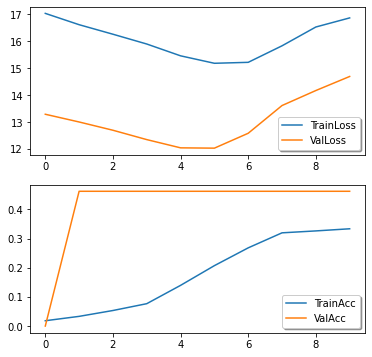

In [63]:
start = time.time()
print('Training attribute extractor...')

MODEL_FILE = '/Users/apple/flickr8k/attribute_extractor_model_weights_v7.hdf5'
EPOCHS = 10

# callback initialization
callbacks = [
    tf.keras.callbacks.ModelCheckpoint( filepath=MODEL_FILE, monitor='val_loss', save_best_only=True,
                                     mode='min', save_weights_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=0.0000001, verbose=1)
]        

# train the model
history = efficientNet_model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds)

print ('Time taken to complete {} sec\n'.format(round(time.time() - start, 3)))  

# plot the history results
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="TrainLoss")
ax[0].plot(history.history['val_loss'], label="ValLoss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="TrainAcc")
ax[1].plot(history.history['val_accuracy'], label="ValAcc")
ax[1].legend(loc='best', shadow=True)
plt.show()

In [27]:
# train_df[train_df["image_name"]=="/Users/apple/rarerabbit_images/.ipynb_checkpoints"]
MODEL_FILE = '/Users/apple/flickr8k/attribute_extractor_model_weights_v7.hdf5'

1/1 [==============================] - 4s 4s/step


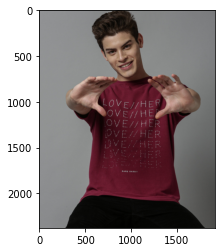

Predicted attributes: ['shirt,men,slim,grey,woman,trouser,fit,sweatshirt,white,maroon']
1/1 [==============================] - 0s 55ms/step


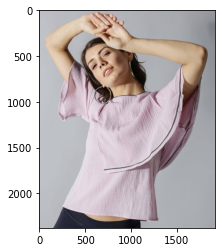

Predicted attributes: ['shirt,men,white,black,plain,fit,woman,top,red,polo']
1/1 [==============================] - 0s 57ms/step


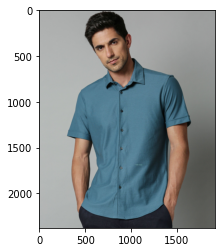

Predicted attributes: ['shirt,men,trouser,white,woman,slim,beig,fit,black,plain']
1/1 [==============================] - 0s 63ms/step


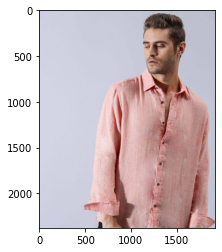

Predicted attributes: ['men,shirt,white,fit,green,print,woman,black,polo,slim']
1/1 [==============================] - 0s 65ms/step


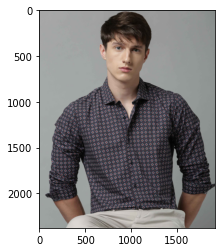

Predicted attributes: ['men,shirt,white,plain,fit,print,green,maroon,black,sweatshirt']


In [64]:
# load the model from disk
efficientNet_model.load_weights(MODEL_FILE)

for index, row in test_df[10:15].iterrows(): 
    image_name = row['image_name']
    #  real_attribute = row['caption_lem']

    # load the image from numpy file in disk
    img_tensor = load_image(image_name)
    # Reshape image to include batch size from (2048) to (1, 2048)
    img_tensor = tf.expand_dims(img_tensor, 0)

    # predict on data
    pred_attribute = efficientNet_model.predict(img_tensor)

    pred_attribute = np.argsort(pred_attribute, axis=1)
    pred_attribute = np.fliplr(pred_attribute[:,-10:])

    # iterates only once as only one row is there
    for row in pred_attribute:
        attrib_list = list()
        for col in row:
            if col == 0:
                attrib_list.append(self.PAD)
            else:
                attrib_list.append(attrib_tokenizer.index_word[col])

        pred_attribute = [",".join(attrib_list)]
        break

    # plot the image 
    plt.imshow(plt.imread(image_name))
    plt.show()
    #  print('Real attributes:', real_attribute)
    print('Predicted attributes:', pred_attribute)

In [1]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [2]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [21]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

NameError: name 'X_train' is not defined

In [14]:
from PIL import Image
im = Image.open("xatay9gawfjpes7uyrzz.webp").convert("RGB")
im.save("food5.jpg","jpeg")

In [ ]:
test1 https://www.azadea.com/en/buy-tezenis-black-ribbed-camisole-with-wide-shoulder-straps/57_1MC1284_019.html?dwvar_57__1MC1284__019_color=5701_019
test2 https://www.azadea.com/en/buy-kiprun-kiprun-womens-2-in-1-running-shorts-with-built-in-tight-shorts-black/54_8577540_000.html?dwvar_54__8577540__000_color=5401_000
test3 https://www.azadea.com/en/buy-tezenis-soft-animal-print-sleeveless-canvas-dress-with-ties/57_1WA1441_852U.html?dwvar_57__1WA1441__852U_color=5701_852U
test4 https://www.azadea.com/en/buy-urban-outfitters-assort-uo-tortoiseshell-taylor-sunglasses/A3_74868258_0000.html
test5 https://www.azadea.com/en/buy-salsa-jeans-beige-high-rise-straight-jeans-with-rips/21_126919_0071.html?dwvar_21__126919__0071_color=2101_0071    